# INDEX
* [Imports and functions](#Imports-and-functions)
* [Configuration](#Configuration)
* [Prepare dataset](#Prepare-dataset)
* [Build model](#Build-model)
    * [Model inputs](#Model-inputs)
    * [Model output](#Model-output)
    * [Model](#Model)
* [Train model](#Train-model)
    * [Save model and resources](#Save-model-and-resources)
    * [Training stats](#Training-stats)
* [Test model](#Test-model)
    * [Predict with training model](#Predict-with-training-model)
    * [Predict with serving model](#Predict-with-serving-model)

In [1]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False
# eventual initialization for colab notebooks
if IN_COLAB:
  # we try hard to be re-entrant,
  # that is to be able to rerun this without cloning repository more than once
  COLAB_BRANCH = "master"
  !curl https://raw.githubusercontent.com/openfoodfacts/off-category-classification/$COLAB_BRANCH/lib/colab.py --output /content/colab.py
  !cd /content && python /content/colab.py $COLAB_BRANCH
  %cd /content/off-category-classification/experiments

In [2]:
# codecarbon - start tracking
from codecarbon import EmissionsTracker

tracker = EmissionsTracker(log_level = "WARNING", save_to_api = True, experiment_id = "6d2c8401-afba-42de-9600-6e95bea5fd80")
tracker.start()

[codecarbon ERROR @ 21:08:47] Unable to read Intel RAPL files for CPU power, we will use a constant for your CPU power. Please view https://github.com/mlco2/codecarbon/issues/244 for workarounds : [Errno 13] Permission denied: '/sys/class/powercap/intel-rapl/intel-rapl:1/energy_uj'
[codecarbon ERROR @ 21:08:47] Unable to read Intel RAPL files for CPU power, we will use a constant for your CPU power. Please view https://github.com/mlco2/codecarbon/issues/244 for workarounds : [Errno 13] Permission denied: '/sys/class/powercap/intel-rapl/intel-rapl:0/energy_uj'
[codecarbon ERROR @ 21:08:48] Unable to read Intel RAPL files for CPU power, we will use a constant for your CPU power. Please view https://github.com/mlco2/codecarbon/issues/244 for workarounds : [Errno 13] Permission denied: '/sys/class/powercap/intel-rapl/intel-rapl:1/energy_uj'
[codecarbon ERROR @ 21:08:48] Unable to read Intel RAPL files for CPU power, we will use a constant for your CPU power. Please view https://github.com/

# Imports

In [3]:
import sys
sys.path.append('../') #append a relative path to the top package to the search path

In [4]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
from tensorflow.keras import callbacks, layers
from tensorflow.keras.utils import plot_model

from lib.dataset import *
from lib.directories import init_cache_dir, init_model_dir
from lib.io import load_model, save_model
from lib.model import top_labeled_predictions, top_predictions_table
from lib.plot import plot_training_stats

# Configuration

In [5]:
MODEL_BASE_DIR = pathlib.Path('../model')
CACHE_DIR = pathlib.Path('../tensorflow_cache')

PREPROC_BATCH_SIZE = 10_000  # some large value, only affects execution time

# splits are handled by `tfds.load`, see doc for more elaborate ways to sample
TRAIN_SPLIT = 'train[0:80%]'
VAL_SPLIT = 'train[80%:90%]'
TEST_SPLIT = 'train[90%:]'
MAX_EPOCHS = 50

# Prepare dataset

Run this once to fetch, build and cache the dataset.
Further runs will be no-ops, unless you force operations (see TFDS doc).

Once this is done, `load_dataset('off_categories', ...)` to access the dataset.

In [6]:
import datasets.off_categories

builder = tfds.builder('off_categories')
builder.download_and_prepare()

# Or run via command line (if `tfds` is in the path):
# !cd ../datasets && tfds build off_categories

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /home/tf/tensorflow_datasets/off_categories/2.0.0.incompleteGZZB0F/off_categories-train.tfrecord*...…

Dataset off_categories downloaded and prepared to /home/tf/tensorflow_datasets/off_categories/2.0.0. Subsequent calls will reuse this data.


# Build model

In [7]:
tf.random.set_seed(42)

# Taxonomy information

In [8]:
import json
from lib.taxonomy_mask import Taxonomy
! ls category_taxonomy.json || wget https://github.com/openfoodfacts/robotoff-models/releases/download/keras-category-classifier-xx-2.0/category_taxonomy.json

taxo = Taxonomy.from_data(json.load(open('category_taxonomy.json')))

category_taxonomy.json


## Model inputs

In [9]:
# we use dicts so rerunning individual model cells is idempotent
inputs = {}
input_graphs = {}

In [10]:
ds = load_dataset('off_categories', split=TRAIN_SPLIT)

In [11]:
%%time

feature_name = 'product_name'

product_name_input = tf.keras.Input(shape=(1,), dtype=tf.string, name=feature_name)

product_name_vectorizer = layers.TextVectorization(
    split = 'whitespace',
    max_tokens = 93_000,
    output_sequence_length = 30)

product_name_vectorizer.adapt(
    select_feature(ds, feature_name).batch(PREPROC_BATCH_SIZE))

x = product_name_vectorizer(product_name_input)

x = layers.Embedding(
    input_dim = product_name_vectorizer.vocabulary_size(),
    output_dim = 64,
    mask_zero = False)(x)

product_name_graph = layers.Bidirectional(layers.LSTM(
    units = 64,
    recurrent_dropout = 0.2,
    dropout = 0.0))(x)

inputs[feature_name] = product_name_input
input_graphs[feature_name] = product_name_graph

len(product_name_vectorizer.get_vocabulary())

CPU times: user 45.1 s, sys: 14.1 s, total: 59.2 s
Wall time: 11 s


93000

In [12]:
%%time

feature_name = 'ingredients_tags'

ingredients_input = tf.keras.Input(shape=(None,), dtype=tf.string, name=feature_name)

ingredients_vocab = get_vocabulary(
    flat_batch(select_feature(ds, feature_name), batch_size=PREPROC_BATCH_SIZE),
    min_freq = 3,
    max_tokens = 5_000)

ingredients_graph = layers.StringLookup(
    vocabulary = ingredients_vocab,
    output_mode = 'multi_hot')(ingredients_input)

inputs[feature_name] = ingredients_input
input_graphs[feature_name] = ingredients_graph

len(ingredients_vocab)

CPU times: user 1min 1s, sys: 19.3 s, total: 1min 20s
Wall time: 12.9 s


5000

## Model output

In [13]:
%%time

labels = 'categories_tags'

categories_vocab = get_vocabulary(
    flat_batch(select_feature(ds, labels), batch_size=PREPROC_BATCH_SIZE),
    min_freq = 10)

# StringLookup(output_mode='multi_hot') mode requires num_oov_indices >= 1.
# We don't want OOVs in the categories_tags output layer, since it wouldn't make
# sense to predict OOV. So we'll drop the OOV in _transform below.
# Be careful when using StringLookup methods, some of them will return values
# based on a vocabulary with OOV (e.g. vocabulary_size()). Keep this in mind when
# mapping predictions back to the original vocabulary.
categories_multihot = layers.StringLookup(
    vocabulary = categories_vocab,
    output_mode = 'multi_hot',
    num_oov_indices = 1)

len(categories_vocab)

CPU times: user 59.5 s, sys: 19.1 s, total: 1min 18s
Wall time: 12.6 s


5205

## Model

In [14]:
# a specific model that do not penalize on certain categories
from lib.taxonomy_mask import MaskingModel

In [57]:
# ensure final order is independent of cell execution/insertion order
features = sorted(inputs.keys())

x = layers.Concatenate()([input_graphs[k] for k in features])
x = layers.Dropout(0.2)(x)
x = layers.Dense(64)(x)
x = layers.Dropout(0.2)(x)
x = layers.Activation('relu')(x)
output = layers.Dense(len(categories_vocab), activation='sigmoid')(x)

model = MaskingModel(inputs=[inputs[k] for k in features], outputs=[output])

threshold = 0.5
num_labels = len(categories_vocab)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.0),
    metrics=[
        tf.metrics.Precision(thresholds=threshold, name='precision'),
        tf.metrics.Recall(thresholds=threshold, name='recall'),
        tfa.metrics.F1Score(average='micro', threshold=threshold, num_classes=num_labels, name='f1_score_micro'),
        tfa.metrics.F1Score(average='macro', threshold=threshold, num_classes=num_labels, name='f1_score_macro'),
    ]
)

In [58]:
model.summary()

Model: "masking_model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 product_name (InputLayer)      [(None, 1)]          0           []                               
                                                                                                  
 text_vectorization (TextVector  (None, 30)          0           ['product_name[0][0]']           
 ization)                                                                                         
                                                                                                  
 ingredients_tags (InputLayer)  [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 30, 64)       5952000     ['text_vectorizatio

In [59]:
plot_model(model, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


# Train model

In [18]:
# helpers to add features and encode
from lib.taxonomy_mask import TaxonomyTransformer, binarize_compat 

add_compatible_categories = TaxonomyTransformer(taxo).add_compatible_categories

In [19]:
def categories_encode(ds: tf.data.Dataset):
    """encode categories

    - as multi-hot for y
    - as a mask for "compat" feature
    """
    @tf.function
    @tf.autograph.experimental.do_not_convert
    def _transform(x, y):
        y = categories_multihot(y)
        y = y[1:]  # drop OOV
        # we also binarize compatibility feature
        x = binarize_compat(x, categories_multihot, "compat")
        return (x, y)

    # applies to non-batched dataset
    return (
        ds
        .map(_transform, num_parallel_calls=tf.data.AUTOTUNE, deterministic=True)
        .apply(filter_empty_labels)
    )

In [20]:
# Remember to clean obsolete dirs once in a while
MODEL_DIR = init_model_dir(MODEL_BASE_DIR)
CACHE_DIR = init_cache_dir(CACHE_DIR)

batch_size = 128

ds_train = (
    load_dataset('off_categories', split=TRAIN_SPLIT, features=features, as_supervised=True)
    .apply(add_compatible_categories)
    .apply(categories_encode)
    .padded_batch(batch_size)
    .cache(str(CACHE_DIR / 'train'))
)

ds_val = (
    load_dataset('off_categories', split=VAL_SPLIT, features=features, as_supervised=True)
    .apply(add_compatible_categories)
    .apply(categories_encode)
    .padded_batch(batch_size)
    .cache(str(CACHE_DIR / 'val'))
)

Model directory: ../model.20220826-211453
Cache directory: ../tensorflow_cache


In [60]:
%%time

history = model.fit(
    ds_train,
    epochs = MAX_EPOCHS,
    validation_data = ds_val,
    callbacks = [
        callbacks.TerminateOnNaN(),
        callbacks.ModelCheckpoint(
            filepath = str(MODEL_DIR / "weights.{epoch:02d}-{val_loss:.4f}"),
            monitor = 'val_loss',
            save_best_only = True,
            save_format = 'tf',
        ),
        # callbacks.EarlyStopping(monitor='f1_score_macro', patience=4),
        callbacks.CSVLogger(str(MODEL_DIR / 'training.log')),
        callbacks.History()
    ]
)

Epoch 1/50


/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['compat'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


   5250/Unknown - 689s 130ms/step - loss: 0.0072 - precision: 0.3446 - recall: 0.2476 - f1_score_micro: 0.2881 - f1_score_macro: 0.0090INFO:tensorflow:Assets written to: ../model.20220826-211453/weights.01-0.0018/assets


INFO:tensorflow:Assets written to: ../model.20220826-211453/weights.01-0.0018/assets


5250/5250 [==============================] - 717s 136ms/step - loss: 0.0072 - precision: 0.3446 - recall: 0.2476 - f1_score_micro: 0.2881 - f1_score_macro: 0.0090 - val_loss: 0.0018 - val_precision: 0.8529 - val_recall: 0.5619 - val_f1_score_micro: 0.6774 - val_f1_score_macro: 0.0275
Epoch 2/50
5250/5250 [==============================] - ETA: 0s - loss: 0.0015 - precision: 0.8188 - recall: 0.6585 - f1_score_micro: 0.7300 - f1_score_macro: 0.0802INFO:tensorflow:Assets written to: ../model.20220826-211453/weights.02-0.0013/assets


INFO:tensorflow:Assets written to: ../model.20220826-211453/weights.02-0.0013/assets


5250/5250 [==============================] - 680s 129ms/step - loss: 0.0015 - precision: 0.8188 - recall: 0.6585 - f1_score_micro: 0.7300 - f1_score_macro: 0.0802 - val_loss: 0.0013 - val_precision: 0.8236 - val_recall: 0.7192 - val_f1_score_micro: 0.7679 - val_f1_score_macro: 0.1245
Epoch 3/50
5250/5250 [==============================] - ETA: 0s - loss: 0.0012 - precision: 0.8125 - recall: 0.7336 - f1_score_micro: 0.7711 - f1_score_macro: 0.1579INFO:tensorflow:Assets written to: ../model.20220826-211453/weights.03-0.0012/assets


INFO:tensorflow:Assets written to: ../model.20220826-211453/weights.03-0.0012/assets


5250/5250 [==============================] - 677s 129ms/step - loss: 0.0012 - precision: 0.8125 - recall: 0.7336 - f1_score_micro: 0.7711 - f1_score_macro: 0.1579 - val_loss: 0.0012 - val_precision: 0.8173 - val_recall: 0.7463 - val_f1_score_micro: 0.7802 - val_f1_score_macro: 0.1950
Epoch 4/50
5250/5250 [==============================] - ETA: 0s - loss: 0.0011 - precision: 0.8104 - recall: 0.7540 - f1_score_micro: 0.7812 - f1_score_macro: 0.2050INFO:tensorflow:Assets written to: ../model.20220826-211453/weights.04-0.0011/assets


INFO:tensorflow:Assets written to: ../model.20220826-211453/weights.04-0.0011/assets


5250/5250 [==============================] - 668s 127ms/step - loss: 0.0011 - precision: 0.8104 - recall: 0.7540 - f1_score_micro: 0.7812 - f1_score_macro: 0.2050 - val_loss: 0.0011 - val_precision: 0.8104 - val_recall: 0.7613 - val_f1_score_micro: 0.7851 - val_f1_score_macro: 0.2344
Epoch 5/50
5250/5250 [==============================] - ETA: 0s - loss: 0.0010 - precision: 0.8100 - recall: 0.7650 - f1_score_micro: 0.7869 - f1_score_macro: 0.2334INFO:tensorflow:Assets written to: ../model.20220826-211453/weights.05-0.0011/assets


INFO:tensorflow:Assets written to: ../model.20220826-211453/weights.05-0.0011/assets


5250/5250 [==============================] - 873s 166ms/step - loss: 0.0010 - precision: 0.8100 - recall: 0.7650 - f1_score_micro: 0.7869 - f1_score_macro: 0.2334 - val_loss: 0.0011 - val_precision: 0.8130 - val_recall: 0.7631 - val_f1_score_micro: 0.7873 - val_f1_score_macro: 0.2584
Epoch 6/50
5250/5250 [==============================] - ETA: 0s - loss: 0.0010 - precision: 0.8097 - recall: 0.7715 - f1_score_micro: 0.7902 - f1_score_macro: 0.2554INFO:tensorflow:Assets written to: ../model.20220826-211453/weights.06-0.0011/assets


INFO:tensorflow:Assets written to: ../model.20220826-211453/weights.06-0.0011/assets


5250/5250 [==============================] - 26205s 5s/step - loss: 0.0010 - precision: 0.8097 - recall: 0.7715 - f1_score_micro: 0.7902 - f1_score_macro: 0.2554 - val_loss: 0.0011 - val_precision: 0.8117 - val_recall: 0.7694 - val_f1_score_micro: 0.7900 - val_f1_score_macro: 0.2736
Epoch 7/50
5250/5250 [==============================] - ETA: 0s - loss: 9.9267e-04 - precision: 0.8100 - recall: 0.7771 - f1_score_micro: 0.7932 - f1_score_macro: 0.2684INFO:tensorflow:Assets written to: ../model.20220826-211453/weights.07-0.0011/assets


INFO:tensorflow:Assets written to: ../model.20220826-211453/weights.07-0.0011/assets


5250/5250 [==============================] - 694s 132ms/step - loss: 9.9267e-04 - precision: 0.8100 - recall: 0.7771 - f1_score_micro: 0.7932 - f1_score_macro: 0.2684 - val_loss: 0.0011 - val_precision: 0.8103 - val_recall: 0.7723 - val_f1_score_micro: 0.7908 - val_f1_score_macro: 0.2889
Epoch 8/50
5250/5250 [==============================] - ETA: 0s - loss: 9.7441e-04 - precision: 0.8099 - recall: 0.7816 - f1_score_micro: 0.7955 - f1_score_macro: 0.2829INFO:tensorflow:Assets written to: ../model.20220826-211453/weights.08-0.0011/assets


INFO:tensorflow:Assets written to: ../model.20220826-211453/weights.08-0.0011/assets


5250/5250 [==============================] - 675s 129ms/step - loss: 9.7441e-04 - precision: 0.8099 - recall: 0.7816 - f1_score_micro: 0.7955 - f1_score_macro: 0.2829 - val_loss: 0.0011 - val_precision: 0.8109 - val_recall: 0.7740 - val_f1_score_micro: 0.7921 - val_f1_score_macro: 0.2979
Epoch 9/50
5250/5250 [==============================] - ETA: 0s - loss: 9.5997e-04 - precision: 0.8104 - recall: 0.7849 - f1_score_micro: 0.7974 - f1_score_macro: 0.2938INFO:tensorflow:Assets written to: ../model.20220826-211453/weights.09-0.0011/assets


INFO:tensorflow:Assets written to: ../model.20220826-211453/weights.09-0.0011/assets


5250/5250 [==============================] - 671s 128ms/step - loss: 9.5997e-04 - precision: 0.8104 - recall: 0.7849 - f1_score_micro: 0.7974 - f1_score_macro: 0.2938 - val_loss: 0.0011 - val_precision: 0.8094 - val_recall: 0.7778 - val_f1_score_micro: 0.7933 - val_f1_score_macro: 0.3088
Epoch 10/50
5250/5250 [==============================] - ETA: 0s - loss: 9.4543e-04 - precision: 0.8103 - recall: 0.7881 - f1_score_micro: 0.7990 - f1_score_macro: 0.3046INFO:tensorflow:Assets written to: ../model.20220826-211453/weights.10-0.0011/assets


INFO:tensorflow:Assets written to: ../model.20220826-211453/weights.10-0.0011/assets


5250/5250 [==============================] - 669s 127ms/step - loss: 9.4543e-04 - precision: 0.8103 - recall: 0.7881 - f1_score_micro: 0.7990 - f1_score_macro: 0.3046 - val_loss: 0.0011 - val_precision: 0.8083 - val_recall: 0.7789 - val_f1_score_micro: 0.7934 - val_f1_score_macro: 0.3165
Epoch 11/50
5250/5250 [==============================] - 670s 128ms/step - loss: 9.3719e-04 - precision: 0.8104 - recall: 0.7903 - f1_score_micro: 0.8002 - f1_score_macro: 0.3123 - val_loss: 0.0011 - val_precision: 0.8066 - val_recall: 0.7815 - val_f1_score_micro: 0.7938 - val_f1_score_macro: 0.3239
Epoch 12/50
5250/5250 [==============================] - ETA: 0s - loss: 9.2578e-04 - precision: 0.8106 - recall: 0.7933 - f1_score_micro: 0.8019 - f1_score_macro: 0.3204INFO:tensorflow:Assets written to: ../model.20220826-211453/weights.12-0.0011/assets


INFO:tensorflow:Assets written to: ../model.20220826-211453/weights.12-0.0011/assets


5250/5250 [==============================] - 672s 128ms/step - loss: 9.2578e-04 - precision: 0.8106 - recall: 0.7933 - f1_score_micro: 0.8019 - f1_score_macro: 0.3204 - val_loss: 0.0011 - val_precision: 0.8069 - val_recall: 0.7827 - val_f1_score_micro: 0.7946 - val_f1_score_macro: 0.3305
Epoch 13/50
5250/5250 [==============================] - 669s 127ms/step - loss: 9.1616e-04 - precision: 0.8108 - recall: 0.7952 - f1_score_micro: 0.8030 - f1_score_macro: 0.3274 - val_loss: 0.0011 - val_precision: 0.8097 - val_recall: 0.7813 - val_f1_score_micro: 0.7952 - val_f1_score_macro: 0.3350
Epoch 14/50
5250/5250 [==============================] - 669s 127ms/step - loss: 9.0826e-04 - precision: 0.8110 - recall: 0.7972 - f1_score_micro: 0.8040 - f1_score_macro: 0.3325 - val_loss: 0.0011 - val_precision: 0.8083 - val_recall: 0.7834 - val_f1_score_micro: 0.7956 - val_f1_score_macro: 0.3399
Epoch 15/50
5250/5250 [==============================] - 671s 128ms/step - loss: 8.9926e-04 - precision: 0.81

KeyboardInterrupt: 

## Training stats

In [61]:
stats = pd.read_csv(MODEL_DIR / 'training.log')
stats

,epoch,f1_score_macro,f1_score_micro,loss,precision,recall,val_f1_score_macro,val_f1_score_micro,val_loss,val_precision,val_recall
0,0,0.009018,0.288130,0.007227,0.344551,0.247587,0.027497,0.677433,0.001835,0.852888,0.561850
1,1,0.080203,0.729987,0.001476,0.818812,0.658547,0.124505,0.767866,0.001264,0.823636,0.719170
2,2,0.157941,0.771051,0.001167,0.812533,0.733599,0.194974,0.780180,0.001175,0.817319,0.746270
3,3,0.205017,0.781168,0.001087,0.810402,0.753969,0.234414,0.785106,0.001142,0.810430,0.761316
4,4,0.233389,0.786850,0.001043,0.809991,0.764995,0.258450,0.787256,0.001128,0.812977,0.763113
5,5,0.255355,0.790161,0.001014,0.809705,0.771537,0.273646,0.789981,0.001116,0.811690,0.769402
6,6,0.268418,0.793203,0.000993,0.810041,0.777051,0.288911,0.790828,0.001112,0.810278,0.772290
7,7,0.282894,0.795505,0.000974,0.809926,0.781590,0.297905,0.792057,0.001105,0.810921,0.774050
8,8,0.293830,0.797406,0.000960,0.810358,0.784861,0.308753,0.793283,0.001104,0.809413,0.777783
9,9,0.304611,0.799046,0.000945,0.810298,0.788102,0.316510,0.793352,0.001099,0.808330,0.778920


In [74]:
%matplotlib inline

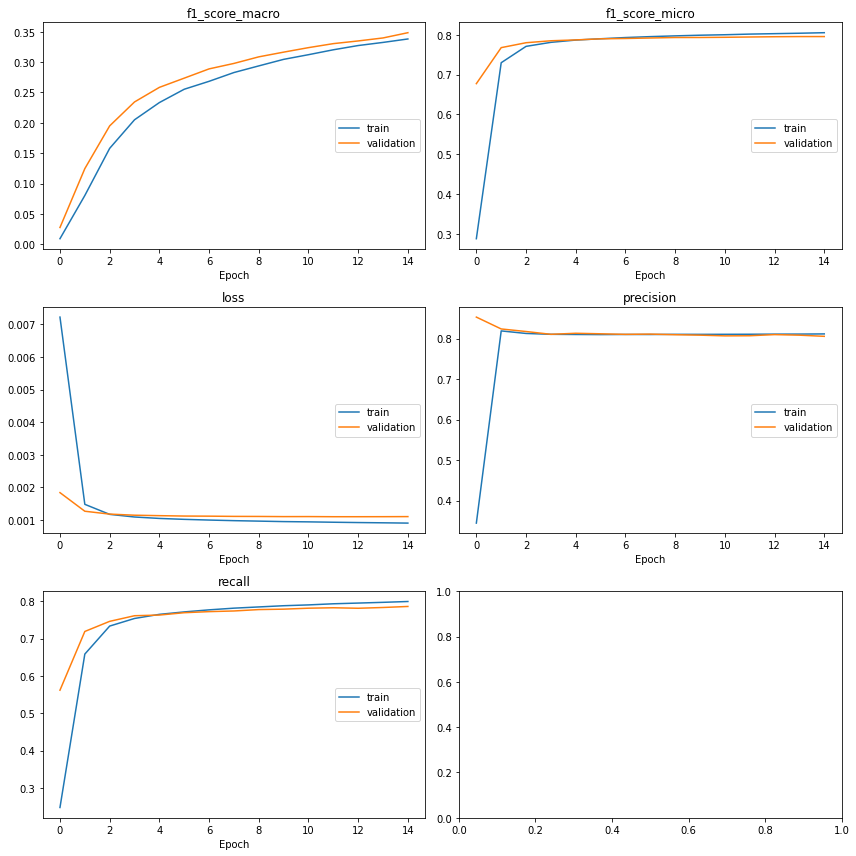

In [75]:
plot_training_stats(stats)

## Save model and resources

In [63]:
SAVED_MODEL_DIR = MODEL_DIR / 'saved_model'

@tf.function
def serving_func(*args, **kwargs):
    preds = model(*args, **kwargs)
    return top_labeled_predictions(preds, categories_vocab, k=50)

save_model(SAVED_MODEL_DIR, model, categories_vocab, serving_func)

INFO:tensorflow:Assets written to: ../model.20220826-211453/saved_model/assets


INFO:tensorflow:Assets written to: ../model.20220826-211453/saved_model/assets


# Test model

In [64]:
m, labels = load_model(SAVED_MODEL_DIR)

In [65]:
ds_test = load_dataset('off_categories', split=TEST_SPLIT)

## Predict with serving model

In [66]:
%%time

preds_test = m.predict(ds_test.padded_batch(128))
preds_test

/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['categories_tags', 'code'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


CPU times: user 54.9 s, sys: 7.7 s, total: 1min 2s
Wall time: 13.4 s


array([[9.91491795e-01, 9.85237837e-01, 1.04595601e-04, ...,
        3.64533750e-12, 1.14021141e-12, 2.51396792e-10],
       [8.87269735e-01, 9.07223523e-01, 1.07419074e-01, ...,
        1.32634306e-10, 8.56369127e-08, 2.84168475e-08],
       [9.37152505e-01, 9.67690229e-01, 3.24915418e-05, ...,
        1.34166398e-12, 9.89221118e-12, 1.26886054e-11],
       ...,
       [2.92406738e-01, 3.03041816e-01, 1.83186263e-01, ...,
        8.62483867e-05, 1.11770714e-04, 7.36787115e-05],
       [1.31514668e-03, 3.91662121e-04, 1.28244653e-06, ...,
        2.46298620e-12, 1.87303688e-12, 7.77159471e-07],
       [3.56311580e-06, 1.76458695e-06, 8.46677125e-01, ...,
        1.52342361e-10, 1.80566631e-10, 2.79441489e-14]], dtype=float32)

In [67]:
# This is the function exported as the default serving function in our saved model
top_preds_test = top_labeled_predictions(preds_test, labels, k=7)
top_preds_test

(<tf.Tensor: shape=(85760, 7), dtype=float32, numpy=
 array([[0.9935262 , 0.9914918 , 0.9880535 , ..., 0.98526764, 0.98523784,
         0.97942305],
        [0.96432817, 0.9306847 , 0.92193973, ..., 0.90680903, 0.88726974,
         0.876057  ],
        [0.9676902 , 0.9587946 , 0.950534  , ..., 0.8960466 , 0.80532694,
         0.7355396 ],
        ...,
        [0.30304182, 0.29240674, 0.18318626, ..., 0.1045565 , 0.07459134,
         0.06976151],
        [0.98434806, 0.97563154, 0.97442585, ..., 0.971689  , 0.97000384,
         0.96071184],
        [0.96264684, 0.9192923 , 0.8466771 , ..., 0.31030446, 0.27608925,
         0.11581901]], dtype=float32)>,
 <tf.Tensor: shape=(85760, 7), dtype=string, numpy=
 array([[b'en:breakfasts', b'en:plant-based-foods-and-beverages',
         b'en:spreads', ..., b'en:plant-based-spreads',
         b'en:plant-based-foods', b'en:fruit-and-vegetable-preserves'],
        [b'en:compotes', b'en:fruits-and-vegetables-based-foods',
         b'en:desserts', ...

In [68]:
%%time

# Same data, but pretty
pred_table_test = top_predictions_table(top_preds_test)

# Add some interpretable features to the final table
# Table must be row-aligned with predictions above (= taken from same data sample)
extra_cols_test = as_dataframe(select_features(ds_test, ['code', 'product_name']))

pd.concat([extra_cols_test, pred_table_test], axis=1)

CPU times: user 27.9 s, sys: 3.52 s, total: 31.4 s
Wall time: 17.4 s


,code,product_name,top prediction 1,top prediction 2,top prediction 3,top prediction 4,top prediction 5,top prediction 6,top prediction 7
0,0637793029422,Blueberry preserve,en:breakfasts: 99.35%,en:plant-based-foods-and-beverages: 99.15%,en:spreads: 98.81%,en:sweet-spreads: 98.66%,en:plant-based-spreads: 98.53%,en:plant-based-foods: 98.52%,en:fruit-and-vegetable-preserves: 97.94%
1,5400141381191,Mousseline de pommes,en:compotes: 96.43%,en:fruits-and-vegetables-based-foods: 93.07%,en:desserts: 92.19%,en:plant-based-foods: 90.72%,en:apple-compotes: 90.68%,en:plant-based-foods-and-beverages: 88.73%,en:fruits-based-foods: 87.61%
2,3250392084080,Choux-Fleurs Bio,en:plant-based-foods: 96.77%,en:leaf-vegetables: 95.88%,en:fruits-and-vegetables-based-foods: 95.05%,en:plant-based-foods-and-beverages: 93.72%,en:vegetables-based-foods: 89.60%,en:frozen-vegetables: 80.53%,en:frozen-cauliflower-florets: 73.55%
3,8425275510085,Aceite de oliva virgen extra,en:vegetable-oils: 99.99%,en:vegetable-fats: 99.98%,en:olive-oils: 99.98%,en:fats: 99.97%,en:virgin-olive-oils: 99.96%,en:extra-virgin-olive-oils: 99.96%,en:plant-based-foods-and-beverages: 99.89%
4,4260193516047,Yörem Ayran,en:dairies: 99.55%,en:beverages: 96.00%,en:fermented-milk-products: 95.77%,en:fermented-foods: 93.69%,en:dairy-drinks: 91.52%,en:fermented-milk-drinks: 90.12%,en:fermented-drinks: 86.42%
...,...,...,...,...,...,...,...,...,...
85755,8410500021757,Oikos tentaciones tarta de arándanos,en:dairies: 96.64%,en:yogurts: 96.20%,en:fermented-milk-products: 95.97%,en:fermented-foods: 94.73%,en:greek-style-yogurts: 59.09%,en:desserts: 25.89%,en:biscuits-and-cakes: 10.73%
85756,0810176020524,Beef jerky,en:snacks: 75.20%,en:dried-meats: 50.71%,en:beef-jerkies: 33.52%,en:meats: 26.49%,en:frozen-foods: 0.89%,en:meals: 0.52%,en:prepared-meats: 0.29%
85757,4820003487471,ідеаль немолоко вівсяне,en:plant-based-foods: 30.30%,en:plant-based-foods-and-beverages: 29.24%,en:snacks: 18.32%,en:beverages: 11.30%,en:cereals-and-potatoes: 10.46%,en:sweet-snacks: 7.46%,en:cereals-and-their-products: 6.98%
85758,7613269520931,Mozzarella,en:fermented-milk-products: 98.43%,en:fermented-foods: 97.56%,en:stretched-curd-cheeses: 97.44%,en:cheeses: 97.26%,en:dairies: 97.17%,en:italian-cheeses: 97.00%,en:mozzarella: 96.07%


In [69]:
# codecarbon - stop tracking
tracker.stop()

[codecarbon WARNING @ 07:34:16] Background scheduler didn't run for a long period (167135s), results might be inaccurate


0.029735942818707534